# 5.3.2 例題 : Kaggleコンテスト「ダークマターの観測」

In [1]:
using Distributed
addprocs(3)

@everywhere using Mamba

In [2]:
using CSV
using DataFrames
using HTTP
using Plots
using LinearAlgebra

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/apple/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228
[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl


In [3]:
r = HTTP.request("GET", "https://git.io/vXLqk");
data = CSV.read(IOBuffer(r.body))
disallowmissing!(data)
first(data, 5)

,GalaxyID,x,y,e1,e2
,String,Float64,Float64,Float64,Float64
1,Galaxy1,162.69,1600.06,0.114664,-0.190326
2,Galaxy2,2272.28,540.04,0.623555,0.214979
3,Galaxy3,3553.64,2697.71,0.283527,-0.30187
4,Galaxy4,1366.51,4110.3,0.36262,-0.000568
5,Galaxy5,4098.39,3414.02,-0.43913,-0.019221


In [4]:
galaxy_position = [data[:x] data[:y]]

578×2 Array{Float64,2}:
  162.69  1600.06
 2272.28   540.04
 3553.64  2697.71
 1366.51  4110.3 
 4098.39  3414.02
 3649.23  3852.94
 1926.03  3097.5 
 3677.65  3000.52
  691.78  4199.06
 2246.89   515.27
 3744.75   940.71
  994.92  4003.35
 2060.3   1319.93
    ⋮            
 3597.27  1685.19
 2433.34  1901.4 
 1378.93  1307.07
 2796.16  2626.98
 1120.02   150.78
 1989.26  3311.57
  487.39  2381.64
 3576.68  2670.2 
  529.32  2188.21
  264.31  4083.7 
 2041.51    27.47
  840.08   532.86

In [5]:
ellpty = [data[:e1] data[:e2]]

578×2 Array{Float64,2}:
  0.114664  -0.190326
  0.623555   0.214979
  0.283527  -0.30187 
  0.36262   -0.000568
 -0.43913   -0.019221
 -0.137081   0.070594
  0.012969   0.258085
  0.072448  -0.173611
  0.154846   0.08308 
  0.559024   0.006138
 -0.136016   0.122976
  0.22694   -0.135647
 -0.429135   0.050928
  ⋮                  
 -0.321566  -0.017269
  0.08319   -0.483621
 -0.192827   0.127714
 -0.288615  -0.104543
  0.013106  -0.03046 
  0.126541   0.272779
  0.128308   0.199721
 -0.304011  -0.087968
 -0.419513   0.295542
 -0.054652  -0.132625
  0.183054  -0.399102
 -0.121471  -0.368851

## 可視化

In [6]:
function draw_sky(gxy_pos, ellpty, scale = 20)
    d = sqrt.(sum(ellpty .^ 2, dims = 2))
    a = 1 ./ (1 .- d)
    b = 1 ./ (1 .+ d)
    theta = vec(atan.(ellpty[:, 2], ellpty[:, 1]) * 0.5)
    
    plt = Plots.plot(size = (800, 800))
    for i in 1:size(gxy_pos, 1)
        theta_i = theta[i]
        rot = [cos(theta_i) -sin(theta_i); sin(theta_i) cos(theta_i)]
        xy = hcat([scale * rot * [a[i] * cos(t), b[i]* sin(t)] + gxy_pos[i, :] for t=0:pi/18:2pi]...)
        Plots.plot!(xy[1,:], xy[2,:], label = "", linewidth = 0, fillalpha = 0.8, fill=(0, :blue))
    end
    plt
end

draw_sky (generic function with 2 methods)

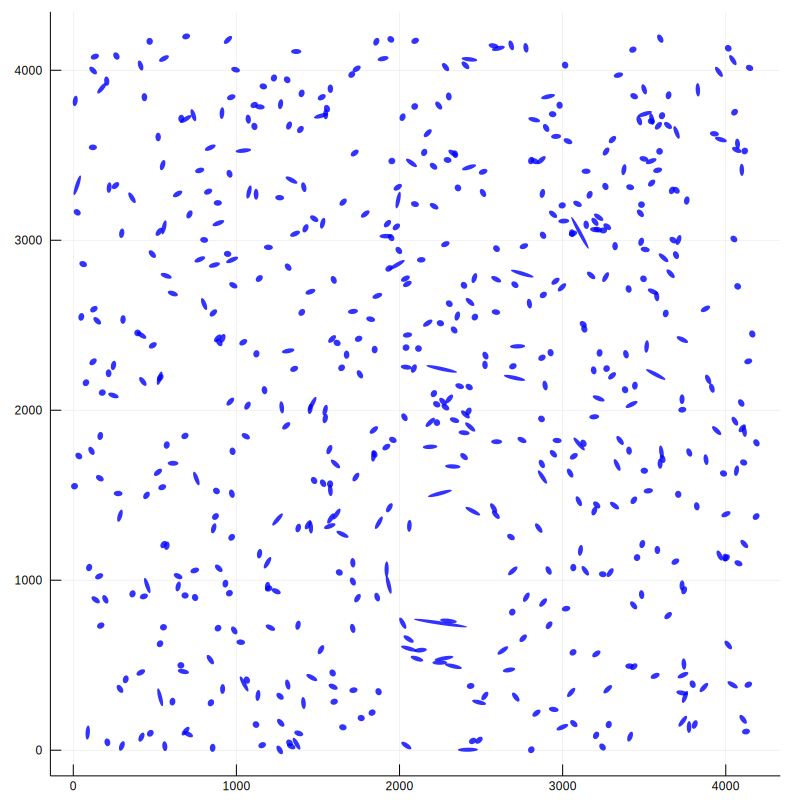

In [7]:
draw_sky(galaxy_position, ellpty)

## サンプルデータの作成

In [100]:
N = 500
mass_large = rand(Uniform(40, 180))
h_pos_sample = rand(Uniform(0, 4200), 2)
gxy_pos_sample = rand(Uniform(0, 4200), (N ,2));

In [101]:
function f_distance(glx_pos, h_pos, c)
    euclidean_distance = sqrt(sum((glx_pos - h_pos) .^ 2))
    max(euclidean_distance, c)
end

function tangential_distance(glx_pos, h_pos)
    delta = glx_pos - h_pos
    t = 2 * atan(delta[2], delta[1])
    [-cos(t), -sin(t)]
end

function ellpty_mean_sample(x)
    mass_large / f_distance(x, h_pos_sample, 240) * tangential_distance(x, h_pos_sample)
end

ellpty_mean_sample (generic function with 1 method)

In [102]:
ellpty_mean_sample_ = mapslices(ellpty_mean_sample, gxy_pos_sample, dims = 2)
ellpty_sample = permutedims(hcat(rand.(MultivariateDistribution[MvNormal(ellpty_mean_sample_[i, :], 0.2) for i in 1:N])...))

500×2 Array{Float64,2}:
  0.10259     0.0170334
  0.0550696   0.0689259
 -0.10632    -0.16575  
  0.102673    0.094418 
  0.0844932  -0.610628 
  0.128241   -0.0553513
  0.40386    -0.0927785
 -0.102108   -0.112807 
 -0.0711787   0.281843 
  0.106124   -0.191079 
 -0.0339349   0.433293 
  0.382341    0.229461 
 -0.155839    0.180408 
  ⋮                    
 -0.212325   -0.354766 
 -0.198466    0.210093 
  0.335159   -0.083653 
 -0.231265    0.0630353
  0.159746    0.168006 
  0.0363677  -0.378777 
  0.0662754  -0.398683 
 -0.207742    0.0718395
  0.291127    0.153881 
  0.089695    0.17988  
 -0.223022   -0.0935988
  0.58945     0.0517213

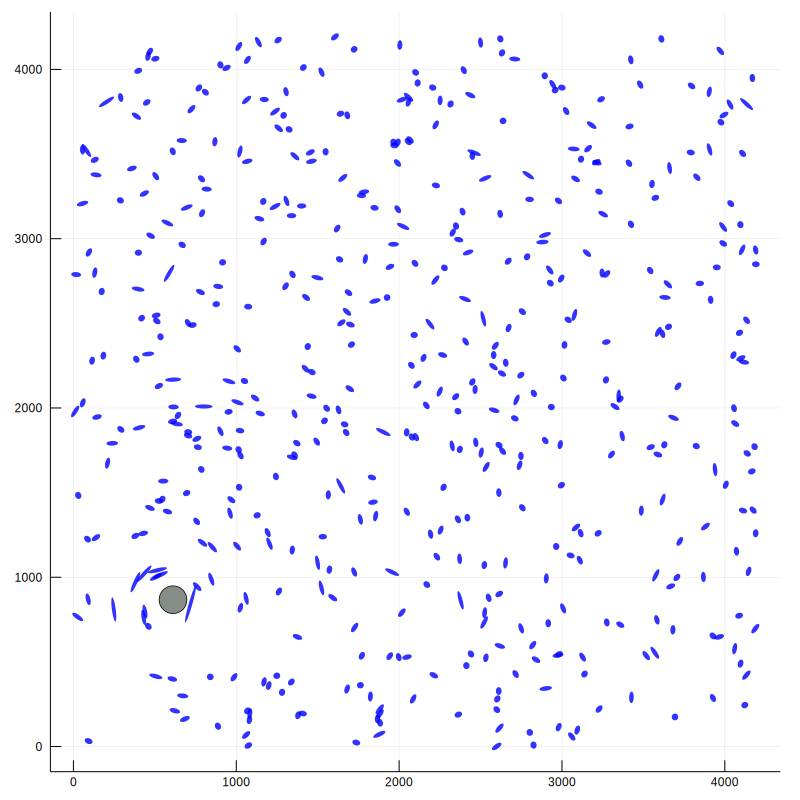

In [103]:
draw_sky(gxy_pos_sample, ellpty_sample)
scatter!(tuple(h_pos_sample...), markersize = 15, label = "")

In [12]:
# model = Model(
#     exp_mass_large = Stochastic(() -> Uniform(40, 180), false),
#     mass_large =  Logical(exp_mass_large -> log.(exp_mass_large)),
#     mean = Logical(1, (N, mass_large) -> fill(mass_large, N)),
#     ellpty = Stochastic(2, (N, mean) -> MultivariateDistribution[MvNormal([mean[i], mean[i]], 0.05) for i in 1:N], false)
# )

In [13]:
# halo_data = Dict(
#     :N => size(data, 1),
#     :ellpty => ellpty,
# )

In [14]:
# inits = [
#     begin
#         x = Dict(
#             :exp_mass_large => rand(Uniform(40, 180)),
#             :mean => fill(2000, halo_data[:N]),
#             :ellpty => halo_data[:ellpty],
#         )
#         x[:mass_large] = log.(x[:exp_mass_large])
#         x
#     end
#     for _ in 1:3
# ]

In [15]:
# scheme = [AMWG(:exp_mass_large, 1)]

In [16]:
# setsamplers!(model, scheme)
# sim = mcmc(model, halo_data, inits, 20000, burnin = 5000, thin = 5, chains = 3)

In [17]:
# describe(sim)

In [18]:
# p = Mamba.plot(sim, legend = true)
# Mamba.draw(p, nrow = 1, ncol = 2)

In [19]:
# p = Mamba.plot(sim, [:autocor, :mean], legend = true)
# Mamba.draw(p, nrow = 1, ncol = 2)